## install lib for hugging face dataset

In [1]:
!pip install datasets
!pip install timm
!pip install scikit-plot
!pip install seaborn



Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip

## prepare dataset

In [2]:
# prepare dataset

from datasets import load_dataset
from torch.utils.data import DataLoader


disease_train = load_dataset('gOLIVES/OLIVES_Dataset', 
                      'disease_classification', 
                      split='train',
                      cache_dir='/home/hice1/zyang717/scratch/eyeDataset'
                     )

print('finish loading disease dataset')

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/38 [00:00<?, ?it/s]

finish loading disease dataset


In [3]:
bio_test = load_dataset('gOLIVES/OLIVES_Dataset', 
                      'biomarker_detection', 
                      split='test',
                      cache_dir='/home/hice1/zyang717/scratch/eyeDataset'
                     )

bio_train = load_dataset('gOLIVES/OLIVES_Dataset', 
                      'biomarker_detection', 
                      split='train',
                      cache_dir='/home/hice1/zyang717/scratch/eyeDataset'
                     )

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/38 [00:00<?, ?it/s]

Using device: cuda
Setting up data augmentation...
Creating datasets...
Calculating class weights...

Class Statistics:
Biomarker 1:
  Positive weight: 0.746
  Negative weight: 1.516
Biomarker 2:
  Positive weight: 1.570
  Negative weight: 0.734
Biomarker 3:
  Positive weight: 0.914
  Negative weight: 1.104
Biomarker 4:
  Positive weight: 1.613
  Negative weight: 0.725
Biomarker 5:
  Positive weight: 1.640
  Negative weight: 0.719
Biomarker 6:
  Positive weight: 1.189
  Negative weight: 0.863
Calculating class weights...

Class Statistics:
Biomarker 1:
  Positive weight: 1.608
  Negative weight: 0.726
Biomarker 2:
  Positive weight: 1.588
  Negative weight: 0.730
Biomarker 3:
  Positive weight: 0.963
  Negative weight: 1.040
Biomarker 4:
  Positive weight: 2.785
  Negative weight: 0.609
Biomarker 5:
  Positive weight: 13.535
  Negative weight: 0.519
Biomarker 6:
  Positive weight: 4.543
  Negative weight: 0.562
Creating data loaders...
Creating ensemble model...
Creating EfficientNet b

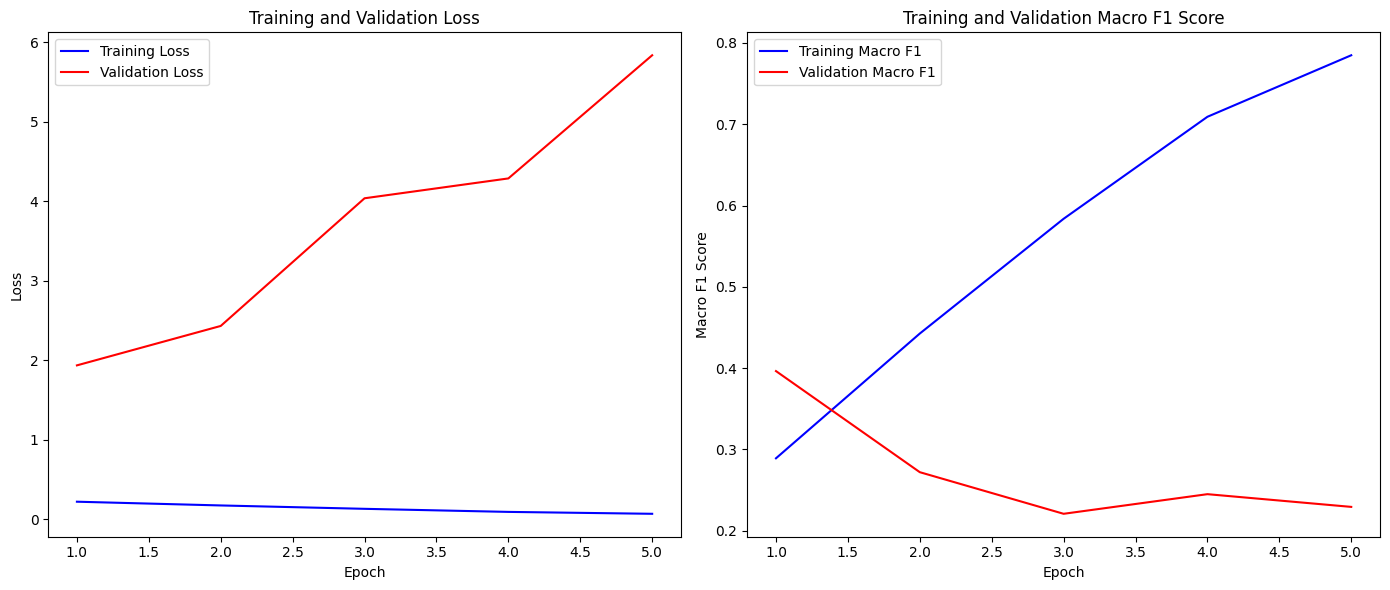

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
import timm
import matplotlib.pyplot as plt
from PIL import Image
from torch.amp import autocast, GradScaler
from torch.utils.data.dataloader import default_collate

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

class WeightedOLIVESDataset(Dataset):
    def __init__(self, dataset, transform=None, is_training=True):
        super().__init__()
        self.dataset = dataset
        self.transform = transform
        self.is_training = is_training
        
        print("Calculating class weights...")
        self.class_weights = self.calculate_class_weights()
        self.print_class_statistics()
    
    def calculate_class_weights(self):
        """计算每个生物标志物类别的权重"""
        pos_counts = torch.zeros(6)
        neg_counts = torch.zeros(6)
        total = len(self.dataset)
        
        for i in range(total):
            sample = self.dataset[i]
            for j in range(6):
                label = sample[f'B{j+1}']
                if label is None or (isinstance(label, float) and np.isnan(label)):
                    continue
                    
                if label == 1:
                    pos_counts[j] += 1
                else:
                    neg_counts[j] += 1
        
        weights = []
        for i in range(6):
            pos = pos_counts[i].item()
            neg = neg_counts[i].item()
            total_valid = pos + neg
            if pos > 0:
                pos_weight = total_valid / (2 * pos)
                neg_weight = total_valid / (2 * neg)
            else:
                pos_weight = 1.0
                neg_weight = 1.0
            weights.append((pos_weight, neg_weight))
            
        return weights
    
    def print_class_statistics(self):
        """打印类别统计信息"""
        print("\nClass Statistics:")
        for i in range(6):
            print(f"Biomarker {i+1}:")
            print(f"  Positive weight: {self.class_weights[i][0]:.3f}")
            print(f"  Negative weight: {self.class_weights[i][1]:.3f}")
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        try:
            item = self.dataset[idx]

            image = item['Image']

            if isinstance(image, Image.Image):
                image = np.array(image)
            elif not isinstance(image, np.ndarray):
                try:
                    image = np.array(image)
                except:
                    if hasattr(image, 'numpy'):
                        image = image.numpy()
            

            if isinstance(image, np.ndarray):
                image = torch.from_numpy(image).float()
            

            if image.dim() == 4:
                image = image.squeeze(0)  
            

            if image.dim() == 3 and image.size(0) not in [1, 3]:
 
                if image.size(-1) in [1, 3]:
                    image = image.permute(2, 0, 1)
                else:

                    image = image.mean(0, keepdim=True)
            elif image.dim() == 2:
                image = image.unsqueeze(0)

            if image.size(0) not in [1, 3]:
                raise ValueError(f"Invalid number of channels: {image.size(0)}")

            image = image / 255.0
            

            labels = []
            for i in range(1, 7):
                label = item[f'B{i}']
                if label is None or (isinstance(label, float) and np.isnan(label)):
                    label = 0.0
                labels.append(float(label))
            
            labels = torch.tensor(labels, dtype=torch.float32)
            weight = self.get_sample_weight(labels)
            
            if self.transform:

                if image.dim() != 3 or image.size(0) not in [1, 3]:
                    raise ValueError(f"Invalid image shape before transform: {image.shape}")
                image = self.transform(image)
                
            return image, labels, weight
            
        except Exception as e:
            print(f"Error processing item {idx}: {str(e)}")
            print(f"Image shape or type: {image.shape if hasattr(image, 'shape') else type(image)}")
            return None
    
    def get_sample_weight(self, labels):
        """计算单个样本的权重"""
        weight = 1.0
        for i, label in enumerate(labels):
            if label == 1:
                weight *= self.class_weights[i][0]
            else:
                weight *= self.class_weights[i][1]
        return torch.tensor(weight, dtype=torch.float32)

class StrongerAugmentation:
    def __init__(self):
        self.train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.RandomRotation(30),
            transforms.RandomAffine(
                degrees=15, 
                translate=(0.15, 0.15),
                scale=(0.85, 1.15),
                shear=(-10, 10)
            ),
            transforms.RandomApply([
                transforms.GaussianBlur(kernel_size=3)
            ], p=0.5),
            transforms.RandomApply([
                transforms.ColorJitter(brightness=0.2, contrast=0.2)
            ], p=0.5),
            transforms.Normalize(mean=[0.485], std=[0.229])
        ])
        
        self.test_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=[0.485], std=[0.229])
        ])

class EfficientNetModel(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()

        self.model = timm.create_model('tf_efficientnetv2_m', pretrained=True)
        

        self.channel_conv = nn.Conv2d(1, 3, kernel_size=1, bias=False)

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):

        x = self.channel_conv(x)
        return self.model(x)

class MaxViTModel(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()

        self.model = timm.create_model('maxvit_base_tf_224', pretrained=True)
        
        self.channel_conv = nn.Conv2d(1, 3, kernel_size=1, bias=False)

        in_features = self.model.head.fc.in_features
        self.model.head.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):

        x = self.channel_conv(x)
        return self.model(x)

class EnsembleModel(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        
        print("Creating EfficientNet branch 1...")
        self.efficient_net_trex_prime = EfficientNetModel(num_classes)
        print("Creating MaxViT branch 1...")
        self.maxvit_trex_prime = MaxViTModel(num_classes)
        print("Creating EfficientNet branch 2...")
        self.efficient_net_trex = EfficientNetModel(num_classes)
        print("Creating MaxViT branch 2...")
        self.maxvit_trex = MaxViTModel(num_classes)
        print("Creating EfficientNet branch 3...")
        self.efficient_net_prime = EfficientNetModel(num_classes)
        

        self.branch_weights = nn.Parameter(
            torch.tensor([0.1, 0.45, 0.1, 0.25, 0.1], device=device),
            requires_grad=False
        )
        
    def forward(self, x):

        out1 = self.efficient_net_trex_prime(x)
        out2 = self.maxvit_trex_prime(x)
        out3 = self.efficient_net_trex(x)
        out4 = self.maxvit_trex(x)
        out5 = self.efficient_net_prime(x)
        

        outputs = [out1, out2, out3, out4, out5]
        weighted_sum = torch.zeros_like(out1)
        for w, out in zip(self.branch_weights, outputs):
            weighted_sum += w * out
            
        return weighted_sum


class MultiLabelMetrics:
   def __init__(self, num_classes=6):
       self.num_classes = num_classes
       self.reset()
       
   def reset(self):
       self.predictions = []
       self.targets = []
       
   def update(self, preds, targets):
       preds = (torch.sigmoid(preds) > 0.5).cpu().numpy()
       targets = targets.cpu().numpy()
       
       self.predictions.append(preds)
       self.targets.append(targets)
       
   def compute(self):
       all_preds = np.concatenate(self.predictions)
       all_targets = np.concatenate(self.targets)
       
       results = {}
       for i in range(self.num_classes):
           results[f'class_{i}_f1'] = f1_score(
               all_targets[:, i], all_preds[:, i], zero_division=0
           )
           results[f'class_{i}_precision'] = precision_score(
               all_targets[:, i], all_preds[:, i], zero_division=0
           )
           results[f'class_{i}_recall'] = recall_score(
               all_targets[:, i], all_preds[:, i], zero_division=0
           )
           
       results['macro_f1'] = f1_score(
           all_targets, all_preds, average='macro', zero_division=0
       )
       results['micro_f1'] = f1_score(
           all_targets, all_preds, average='micro', zero_division=0
       )
       
       return results
   
   def print_metrics(self, results):
       print("\nMetrics Summary:")
       print(f"Macro F1: {results['macro_f1']:.3f}")
       print(f"Micro F1: {results['micro_f1']:.3f}")
       print("\nPer-class metrics:")
       for i in range(self.num_classes):
           print(f"\nBiomarker {i+1}:")
           print(f"  F1: {results[f'class_{i}_f1']:.3f}")
           print(f"  Precision: {results[f'class_{i}_precision']:.3f}")
           print(f"  Recall: {results[f'class_{i}_recall']:.3f}")


class WeightedBCEWithLogitsLoss(nn.Module):
   def __init__(self, pos_weights=None):
       super().__init__()
       self.pos_weights = pos_weights
       
   def forward(self, predictions, targets, sample_weights=None):
       loss = 0
       for i in range(predictions.shape[1]):
           pos_weight = self.pos_weights[i] if self.pos_weights is not None else None
           bce = F.binary_cross_entropy_with_logits(
               predictions[:, i],
               targets[:, i],
               pos_weight=pos_weight if pos_weight is not None else None,
               reduction='none'
           )
           if sample_weights is not None:
               bce = bce * sample_weights
           loss += bce.mean()
       return loss / predictions.shape[1]


def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    metrics = MultiLabelMetrics()
    total_loss = 0
    scaler = GradScaler('cuda')  
    
    for batch_idx, batch in enumerate(train_loader):
        if batch is None:
            print(f"Skipping batch {batch_idx} due to collate_fn error.")
            continue  # 跳过当前批次

        images, labels, weights = batch
        images = images.to(device)
        labels = labels.to(device)
        weights = weights.to(device)
        
        optimizer.zero_grad()
        with autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels, weights)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        metrics.update(outputs, labels)
        
        if (batch_idx + 1) % 50 == 0:
            print(f'Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / len(train_loader)
    results = metrics.compute()
    return avg_loss, results

@torch.no_grad()
def validate(model, val_loader, criterion):
    model.eval()
    metrics = MultiLabelMetrics()
    total_loss = 0
    
    for batch_idx, batch in enumerate(val_loader):
        if batch is None:
            print(f"Skipping batch {batch_idx} during validation due to collate_fn error.")


        images, labels, weights = batch
        
        images = images.to(device)
        labels = labels.to(device)
        weights = weights.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels, weights)
        
        total_loss += loss.item()
        metrics.update(outputs, labels)
    
    avg_loss = total_loss / len(val_loader)
    results = metrics.compute()
    return avg_loss, results

def train_model(model, train_loader, val_loader, num_epochs=10):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    criterion = WeightedBCEWithLogitsLoss()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    best_val_f1 = 0
    
    train_losses = []
    val_losses = []
    train_macro_f1s = []
    val_macro_f1s = []
    train_micro_f1s = []
    val_micro_f1s = [] 
    
    train_metrics_all = {'epochs': []}
    val_metrics_all = {'epochs': []}
    
    num_classes = 6
    metrics_keys = ['macro_f1', 'micro_f1']
    per_class_metrics = ['f1', 'precision', 'recall', 'accuracy']
    
    for key in metrics_keys:
        train_metrics_all[key] = []
        val_metrics_all[key] = []
    
    for i in range(num_classes):
        for metric in per_class_metrics:
            key = f'B{i+1}_{metric}'
            train_metrics_all[key] = []
            val_metrics_all[key] = []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch [{epoch+1}/{num_epochs}]')
        
        train_loss, train_metrics = train_one_epoch(
            model, train_loader, criterion, optimizer
        )
        
        val_loss, val_metrics = validate(model, val_loader, criterion)
        metrics = MultiLabelMetrics()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_macro_f1s.append(train_metrics['macro_f1'])
        val_macro_f1s.append(val_metrics['macro_f1'])
        train_micro_f1s.append(train_metrics['micro_f1'])
        val_micro_f1s.append(val_metrics['micro_f1'])
        
        print(f'\nTraining - Loss: {train_loss:.4f}')
        print('Training Metrics:')
        metrics.print_metrics(train_metrics)
        
        print(f'\nValidation - Loss: {val_loss:.4f}')
        print('Validation Metrics:')
        metrics.print_metrics(val_metrics)
        
        if val_metrics['macro_f1'] > best_val_f1:
            best_val_f1 = val_metrics['macro_f1']
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'New best model saved! F1: {best_val_f1:.4f}')
        
        scheduler.step()
        
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_macro_f1s': train_macro_f1s,
        'val_macro_f1s': val_macro_f1s,
        'train_micro_f1s': train_micro_f1s,
        'val_micro_f1s': val_micro_f1s
        'train_metrics': train_metrics_all,
        'val_metrics': val_metrics_all,
        'train_losses': train_losses,
        'val_losses': val_losses
    }
def custom_collate_fn(batch):
    batch = [x for x in batch if x is not None]  
    if len(batch) == 0:
        return None 
    try:
        return default_collate(batch)
    except Exception as e:
        print(f"Error in collate_fn: {e}")
        return None 
    

def main():
    print("Setting up data augmentation...")
    augmentation = StrongerAugmentation()

    print("Creating datasets...")
    train_dataset_weighted = WeightedOLIVESDataset(
        bio_train, 
        transform=augmentation.train_transform, 
        is_training=True
    )
    val_dataset_weighted = WeightedOLIVESDataset(
        bio_test, 
        transform=augmentation.test_transform, 
        is_training=False
    )

    print("Creating data loaders...")
    train_loader = DataLoader(
        train_dataset_weighted,
        batch_size=32,
        shuffle=True,
        num_workers=4,  
        collate_fn=custom_collate_fn
    )

    val_loader = DataLoader(
        val_dataset_weighted,
        batch_size=32,
        shuffle=False,
        num_workers=4,
        collate_fn=custom_collate_fn
    )

    print("Creating ensemble model...")
    model = EnsembleModel()
    model = model.to(device)
    print("Model created successfully!")

    print("\nStarting training...")
    history = train_model(model, train_loader, val_loader, num_epochs=5)
    plot_training_history(history)

if __name__ == "__main__":
    main()

In [ ]:

import torch
import torch.nn as nn


model = EnsembleModel()
model = model.to(device)


model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval() 


Creating EfficientNet branch 1...
Creating MaxViT branch 1...
Creating EfficientNet branch 2...
Creating MaxViT branch 2...
Creating EfficientNet branch 3...


/scratch/999267/ipykernel_2976437/300071682.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth', map_location=device))


In [12]:

from torch.utils.data import DataLoader


augmentation = StrongerAugmentation()

val_dataset_weighted = WeightedOLIVESDataset(
    bio_test, 
    transform=augmentation.test_transform, 
    is_training=False
)


val_loader = DataLoader(
    val_dataset_weighted,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    collate_fn=custom_collate_fn
)


Calculating class weights...

Class Statistics:
Biomarker 1:
  Positive weight: 1.608
  Negative weight: 0.726
Biomarker 2:
  Positive weight: 1.588
  Negative weight: 0.730
Biomarker 3:
  Positive weight: 0.963
  Negative weight: 1.040
Biomarker 4:
  Positive weight: 2.785
  Negative weight: 0.609
Biomarker 5:
  Positive weight: 13.535
  Negative weight: 0.519
Biomarker 6:
  Positive weight: 4.543
  Negative weight: 0.562


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc


@torch.no_grad()
def collect_predictions(model, val_loader):
    model.eval()
    all_probs = []
    all_labels = []
    
    for batch_idx, batch in enumerate(val_loader):
        if batch is None:
            continue  

        images, labels, _ = batch
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy()
        labels = labels.cpu().numpy()
        
        all_probs.append(probs)
        all_labels.append(labels)
    
    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    return all_probs, all_labels


def plot_prediction_scatter(all_probs, all_labels, num_classes=6):
    plt.figure(figsize=(14, 8))
    for i in range(num_classes):
        plt.subplot(2, 3, i+1)
        plt.scatter(all_labels[:, i], all_probs[:, i], alpha=0.5)
        plt.xlabel('True Label')
        plt.ylabel('Predicted Probability')
        plt.title(f'Biomarker {i+1}')
        plt.xticks([0, 1])
        plt.yticks(np.linspace(0, 1, 11))
    plt.tight_layout()
    plt.show()


def plot_precision_recall(all_probs, all_labels, num_classes=6):
    plt.figure(figsize=(14, 8))
    for i in range(num_classes):
        precision, recall, thresholds = precision_recall_curve(all_labels[:, i], all_probs[:, i])
        plt.subplot(2, 3, i+1)
        plt.step(recall, precision, where='post', alpha=0.5)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Biomarker {i+1} PR Curve')
        plt.xlim([0.0, 1.05])
        plt.ylim([0.0, 1.05])
    plt.tight_layout()
    plt.show()


def plot_roc_curves(all_probs, all_labels, num_classes=6):
    plt.figure(figsize=(14, 8))
    for i in range(num_classes):
        fpr, tpr, thresholds = roc_curve(all_labels[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.subplot(2, 3, i+1)
        plt.plot(fpr, tpr, alpha=0.5)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Biomarker {i+1} ROC Curve (AUC = {roc_auc:.2f})')
        plt.xlim([0.0, 1.05])
        plt.ylim([0.0, 1.05])
    plt.tight_layout()
    plt.show()


all_probs, all_labels = collect_predictions(model, val_loader)
plot_prediction_scatter(all_probs, all_labels)
plot_precision_recall(all_probs, all_labels)
plot_roc_curves(all_probs, all_labels)


In [14]:
import numpy as np
import torch

@torch.no_grad()
def collect_predictions(model, val_loader):
    model.eval()
    all_probs = []
    all_labels = []
    
    for batch_idx, batch in enumerate(val_loader):
        if batch is None:
            continue  

        images, labels, _ = batch
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy()
        labels = labels.cpu().numpy()
        
        all_probs.append(probs)
        all_labels.append(labels)
    
    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    return all_probs, all_labels


In [15]:
import matplotlib.pyplot as plt

def plot_prediction_scatter(all_probs, all_labels, num_classes=6):
    plt.figure(figsize=(14, 8))
    for i in range(num_classes):
        plt.subplot(2, 3, i+1)
        plt.scatter(all_labels[:, i], all_probs[:, i], alpha=0.5)
        plt.xlabel('True Label')
        plt.ylabel('Predicted Probability')
        plt.title(f'Biomarker {i+1}')
        plt.xticks([0, 1])
        plt.yticks(np.linspace(0, 1, 11))
    plt.tight_layout()
    plt.show()


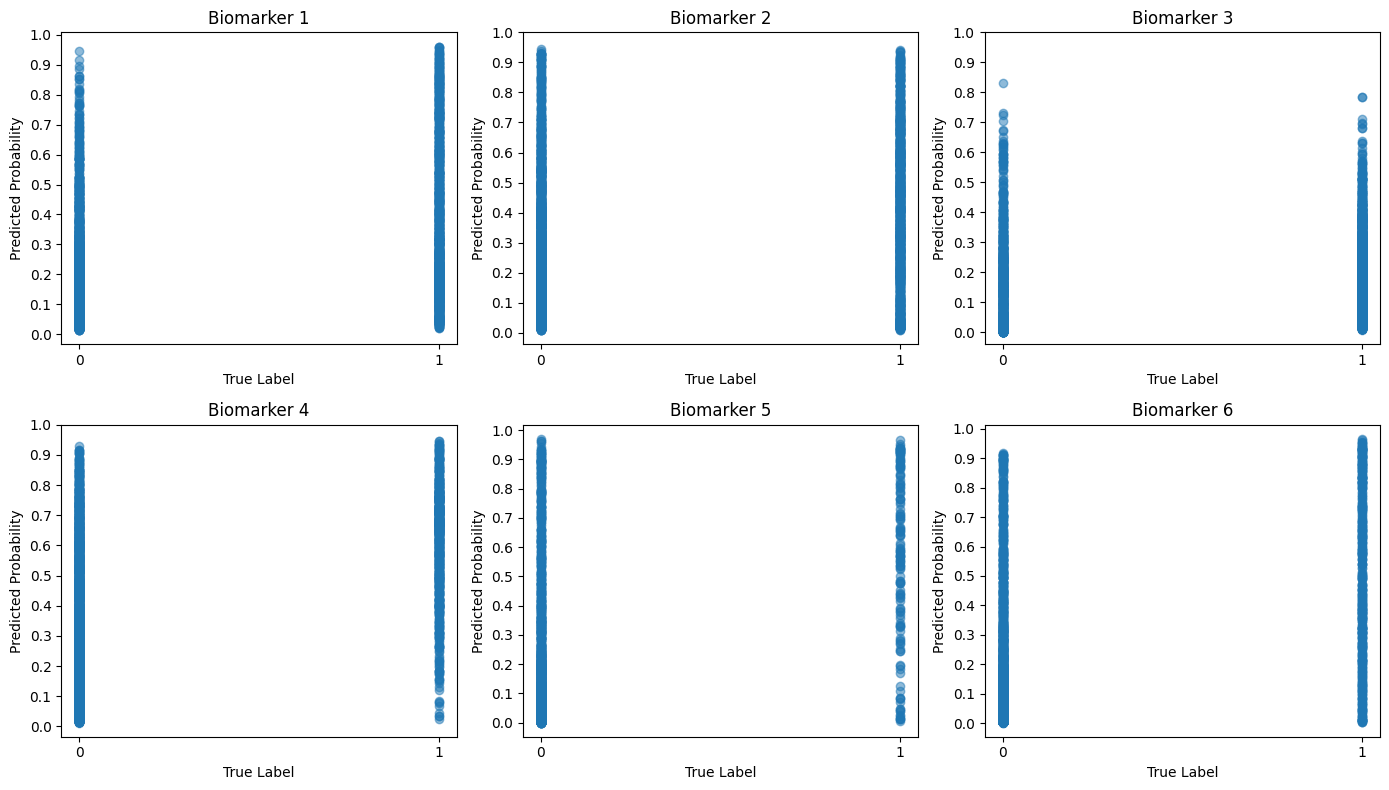

In [16]:

all_probs, all_labels = collect_predictions(model, val_loader)


plot_prediction_scatter(all_probs, all_labels)


In [17]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall(all_probs, all_labels, num_classes=6):
    plt.figure(figsize=(14, 8))
    for i in range(num_classes):
        precision, recall, thresholds = precision_recall_curve(all_labels[:, i], all_probs[:, i])
        plt.subplot(2, 3, i+1)
        plt.step(recall, precision, where='post', alpha=0.5)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Biomarker {i+1} PR Curve')
        plt.xlim([0.0, 1.05])
        plt.ylim([0.0, 1.05])
    plt.tight_layout()
    plt.show()


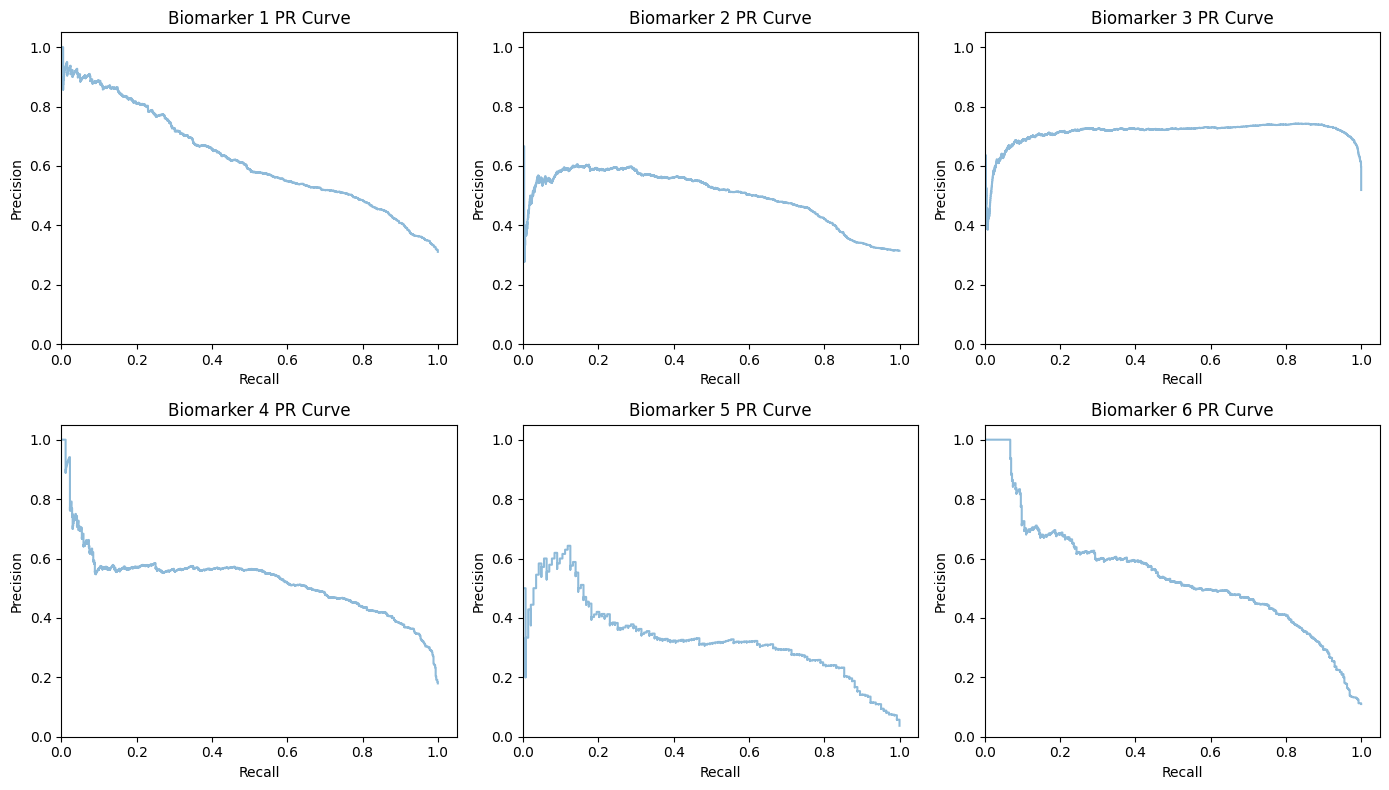

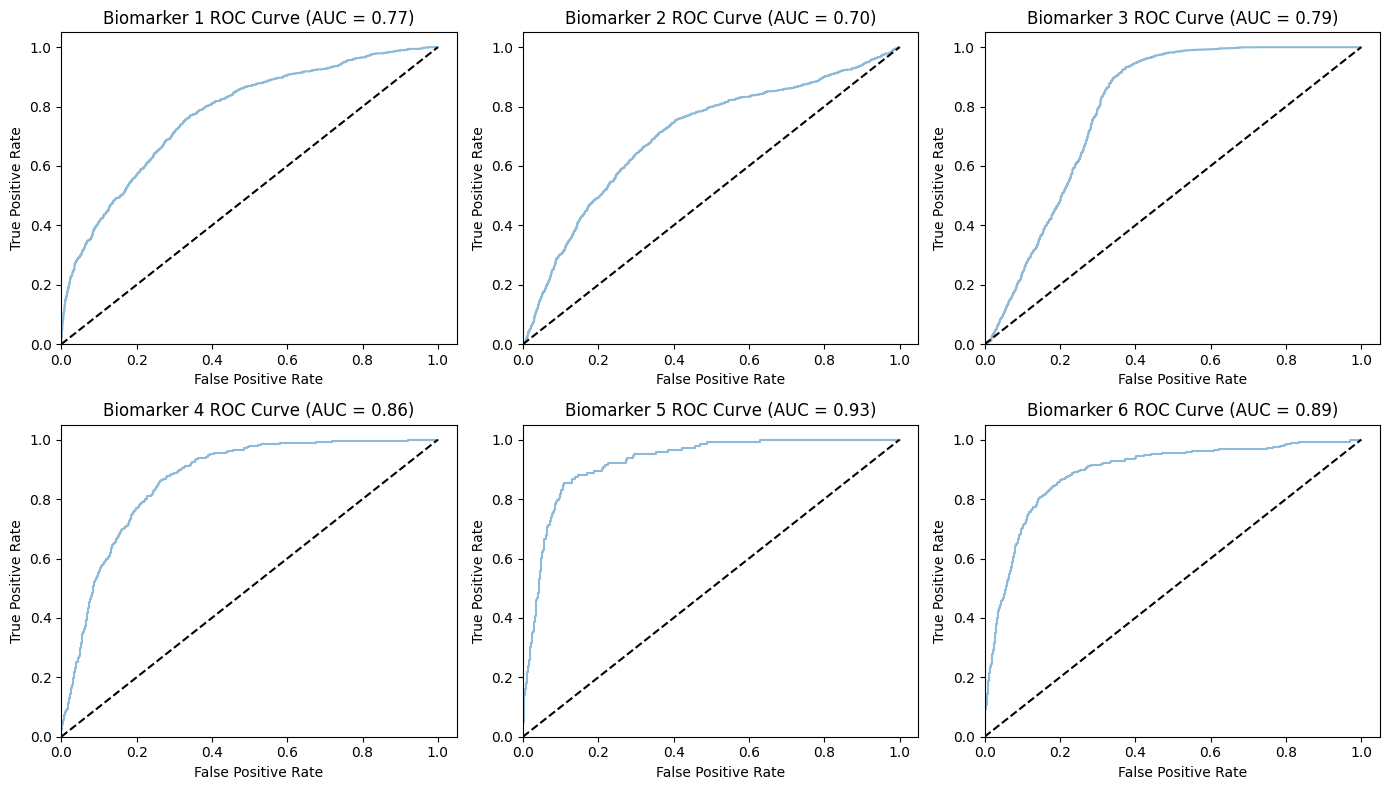

In [18]:
plot_precision_recall(all_probs, all_labels)
plot_roc_curves(all_probs, all_labels)



In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrices(all_preds, all_labels, num_classes=6):
    for i in range(num_classes):
        cm = confusion_matrix(all_labels[:, i], all_preds[:, i])
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix for Biomarker {i+1}')
        plt.show()


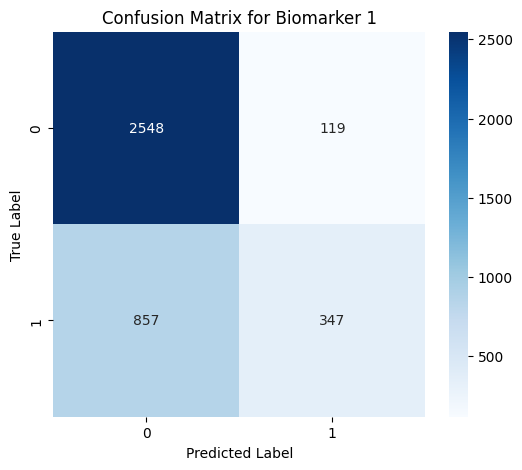

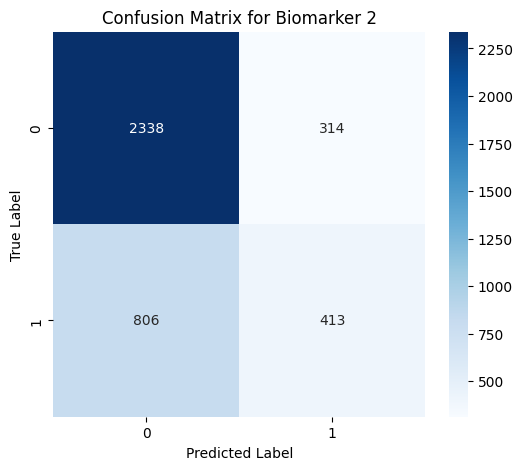

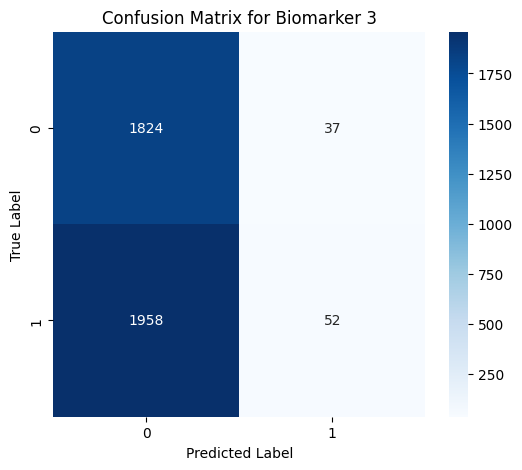

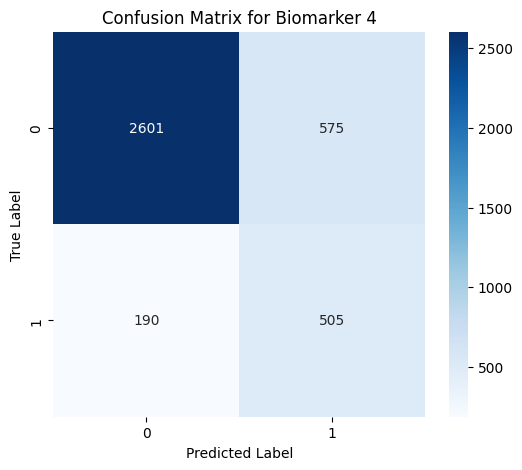

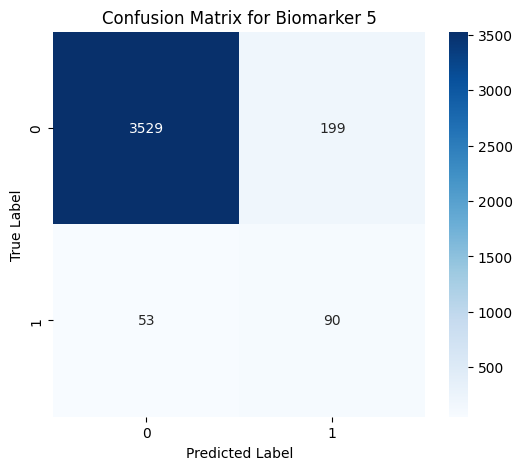

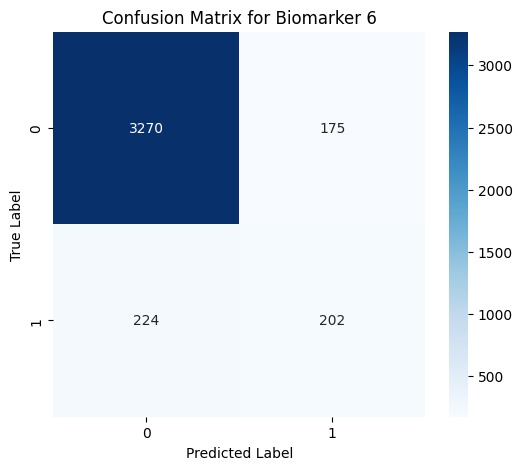

In [26]:

@torch.no_grad()
def collect_predictions_labels(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    for batch_idx, batch in enumerate(val_loader):
        if batch is None:
            continue 

        images, labels, _ = batch
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
        labels = labels.cpu().numpy()
        
        all_preds.append(preds)
        all_labels.append(labels)
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    return all_preds, all_labels


all_preds, all_labels = collect_predictions_labels(model, val_loader)

plot_confusion_matrices(all_preds, all_labels)

